<hr>
<h1><b><center>Exploratory Data Analysis of Comext data for 2020</center></b></h1>
<hr>



In this notebook I have conducted an exploratory data analysis on the "full202052" dataset, which contains statistics on international trade in goods for the year 2020. Some of the main findings are:
<ul>
<li>In 2020, motor vehicles and pharmaceutical preparations were the largest export items (measured in value in euros) in terms of overall, intra-, and extra-EU trade as well. </li>
<li>In 2020, German exports were worth twice as much (in terms of value in euros) as the exports of any other EU country. Unsurprisingly, their highest valued export products were motor vehicles and pharmaceutical preparations</li>
</ul>

Additionally, I also wanted to see whether there is a difference between the top exporters of a product when the exports are measured by quantity not by value of the product. For this, I have chosen to examine wine exports as there exists data on both its value and quantity. 

<ul> 
<li> I have found that while France was the wine exporter with the highest value in euros, in terms of quantity, Spain was the largest wine exporter in 2020.

## Read in data


In [ ]:
!wget -O data.7z "https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&downfile=comext%2FCOMEXT_DATA%2FPRODUCTS%2Ffull202052.7z"
!7z x data.7z

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", context="notebook", palette="pastel")

In [3]:
raw_data = pd.read_csv("full202052.dat")
raw_data

DECLARANT DECLARANT_ISO  ...  QUANTITY_IN_KG SUP_QUANTITY
0                1            FR  ...            3765          333
1                1            FR  ...            6000           12
2                1            FR  ...              10            1
3                1            FR  ...            2500            5
4                1            FR  ...           35760           72
...            ...           ...  ...             ...          ...
9160324        600            CY  ...             882            0
9160325        600            CY  ...               1            0
9160326        600            CY  ...               5            0
9160327        600            CY  ...      1106409648            0
9160328        600            CY  ...            2970            0

[9160329 rows x 20 columns]

After identifying that the database contains data on international trade in goods for 2020, I have used the files in the Classifications and relations folder in order to identify the codes of some of the features.
(The Classifications and relations folder can be found under: https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&dir=comext%2FCOMEXT_METADATA)

## Exploratory Analysis

First, I want to check what features are included in the dataset and their data types.

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9160329 entries, 0 to 9160328
Data columns (total 20 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   DECLARANT        int64 
 1   DECLARANT_ISO    object
 2   PARTNER          int64 
 3   PARTNER_ISO      object
 4   TRADE_TYPE       object
 5   PRODUCT_NC       object
 6   PRODUCT_SITC     object
 7   PRODUCT_CPA2002  object
 8   PRODUCT_CPA2008  object
 9   PRODUCT_CPA2_1   object
 10  PRODUCT_BEC      object
 11  PRODUCT_BEC5     object
 12  PRODUCT_SECTION  object
 13  FLOW             int64 
 14  STAT_REGIME      int64 
 15  SUPP_UNIT        object
 16  PERIOD           int64 
 17  VALUE_IN_EUROS   int64 
 18  QUANTITY_IN_KG   int64 
 19  SUP_QUANTITY     int64 
dtypes: int64(8), object(12)
memory usage: 1.4+ GB


Then I look at the descriptives of the objects.

In [5]:
raw_data.describe(include=['object'])

DECLARANT_ISO PARTNER_ISO  ... PRODUCT_SECTION SUPP_UNIT
count        9160329     9154385  ...         9160329   2612775
unique            28         245  ...              22        27
top               DE          GB  ...              16         A
freq          800305      397585  ...         1996503   1848368

[4 rows x 12 columns]

Check the unique values for TRADE_TYPE and FLOW.

In [6]:
raw_data["TRADE_TYPE"].value_counts()

E    4505790
I    4417243
K     237296
Name: TRADE_TYPE, dtype: int64

We can see that for 2020 there were three different trade types which stand for:
* I Intra-EU Trade (excluding partner GB from February 2020)
* E	Extra-EU Trade (excluding partner GB whatever the reference period)
* K	Trade with partner GB from February until December 2020

Hence, most of the trade was Extra-EU trade in 2020


In [7]:
raw_data["FLOW"].value_counts()

2    5314231
1    3846098
Name: FLOW, dtype: int64

Based on the FLOW we can also see that in 2020 most of the international trade in the EU was exports (Class 2) 

As 


> PRODUCT_NC, PRODUCT_SITC, PRODUCT_CPA2002, PRODUCT_CPA2008, PRODUCT_CPA2_1, PRODUCT_BEC, PRODUCT_BEC5, PRODUCT_SECTION

are all different product classifications, I will use CPA_2_1 as it is neither too narrow nor too broad in its classification. 

In order to identify which code stands for what product I will read in the description of the CPA_2_1 codes from the Bulk Download facility.

In [ ]:
!wget -O CPA2_1.txt "https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=comext%2FCOMEXT_METADATA%2FCLASSIFICATIONS_AND_RELATIONS%2FENGLISH%2FCPA21.txt"

In [9]:
CPA_list = pd.read_csv('CPA2_1.txt', delimiter = "\t", header=None, names=["CODE", "DESCRIPTION"])
CPA_list

CODE                                        DESCRIPTION
0         01  Products of agriculture, hunting and related s...
1        011                                Non-perennial crops
2       0111  Cereals (except rice), leguminous crops and oi...
3      01111                                              Wheat
4     011111                                        Durum wheat
...      ...                                                ...
5633    WWWW                                Parts for aircrafts
5634  WWWW00                                Parts for aircrafts
5635      YY     Adjustments (not broken down at chapter level)
5636    YYYY     Adjustments (not broken down at chapter level)
5637  YYYY00     Adjustments (not broken down at chapter level)

[5638 rows x 2 columns]

### 1. Check what the biggest export products were in 2020 in terms of value

In [10]:
# Query the largest export items based on "VALUE_IN_EUROS"
largest_exports = raw_data[(raw_data["FLOW"]==2)].groupby(["PRODUCT_CPA2_1"])["VALUE_IN_EUROS"].sum().nlargest(11, keep="first")
print(largest_exports, end="\n\n")

# Create a list of labels for the top export items
largest_exports_labels = []
for code in largest_exports.index.tolist():
  largest_exports_labels.append(CPA_list[CPA_list["CODE"] == code].iloc[0]["DESCRIPTION"])

PRODUCT_CPA2_1
TOTAL    4810810128465
2910      377118406502
2120      364902801079
2932      139608625056
1920      111015790976
2014      108230112933
2620      107262566536
2630       99927759922
3030       92630345457
3250       82183156658
SSSS       81113692825
Name: VALUE_IN_EUROS, dtype: int64



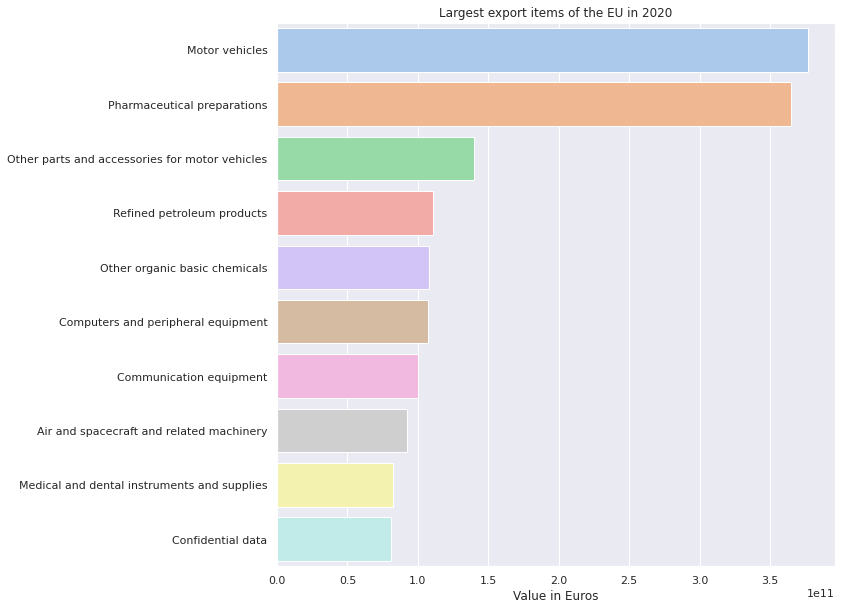

In [11]:
# Plot the largest export items
plt.figure(figsize=(10,10))
sns.barplot(x=largest_exports.values[1:], y=largest_exports_labels[1:])
plt.title("Largest export items of the EU in 2020")
plt.xlabel("Value in Euros")
plt.show()

We can see that the largest export items (in terms of value) in the EU were motor vehicles, closely followed by pharmaceutical preparations.

### 2. Check what the biggest export products were in extra-EU trade in 2020 in terms of value

In [12]:
# Query the largest export items in extra-EU trade based on "VALUE_IN_EUROS"
largest_exports_extra = raw_data[(raw_data["FLOW"]==2) & (raw_data["TRADE_TYPE"]=='E')].groupby(["PRODUCT_CPA2_1"])["VALUE_IN_EUROS"].sum().nlargest(11, keep="first")
print(largest_exports_extra, end="\n\n")

# Create a list of labels for the top export items
largest_exports_extra_labels = []
for code in largest_exports_extra.index.tolist():
  largest_exports_extra_labels.append(CPA_list[CPA_list["CODE"] == code].iloc[0]["DESCRIPTION"])

PRODUCT_CPA2_1
TOTAL    1671819830858
2120      175606912379
2910      119967422520
3030       57150721725
1920       46308411131
2014       37956582863
2932       37431725194
2651       36385758663
3250       36347833425
2899       35469471136
SSSS       34261141366
Name: VALUE_IN_EUROS, dtype: int64



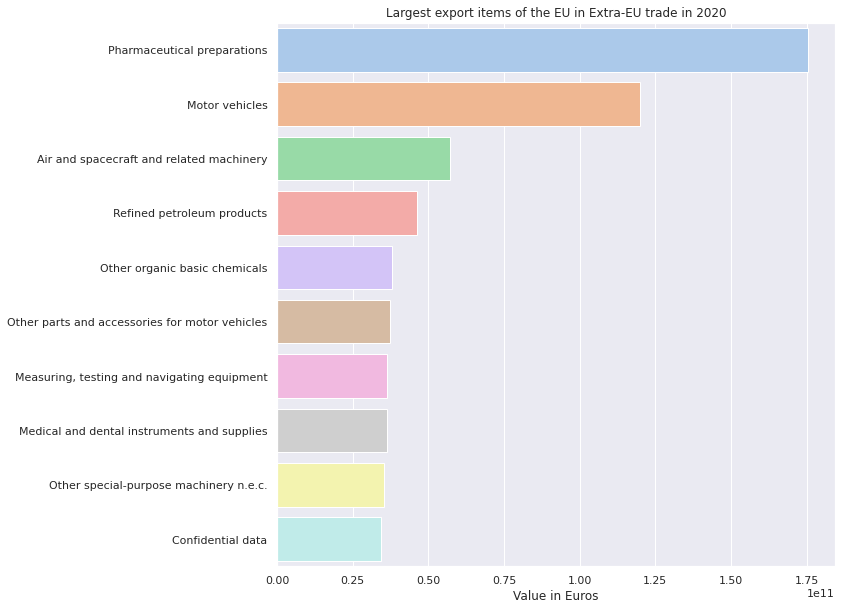

In [13]:
# Plot the largest extra-EU export items
plt.figure(figsize=(10,10))
sns.barplot(x=largest_exports_extra.values[1:], y=largest_exports_extra_labels[1:])
plt.title("Largest export items of the EU in Extra-EU trade in 2020")
plt.xlabel("Value in Euros")
plt.show()

We can see that in 2020 pharmaceutical preparations were the most exported products in terms of value in extra EU trade.

### 3. Check what the biggest export products were in intra-EU trade in 2020 in terms of value

In [14]:
# Query the largest export items in intra-EU trade based on "VALUE_IN_EUROS"
largest_exports_intra = raw_data[(raw_data["FLOW"]==2) & (raw_data["TRADE_TYPE"]=='I')].groupby(["PRODUCT_CPA2_1"])["VALUE_IN_EUROS"].sum().nlargest(11, keep="first")
print(largest_exports_intra, end="\n\n")

# Create a list of labels for the top export items
largest_exports_intra_labels = []
for code in largest_exports_intra.index.tolist():
  largest_exports_intra_labels.append(CPA_list[CPA_list["CODE"] == code].iloc[0]["DESCRIPTION"])

PRODUCT_CPA2_1
TOTAL    2886122680587
2910      226557593480
2120      174394411989
2932       95755903626
2620       78018701709
2630       72449765436
2014       66223957585
1920       61030372996
2410       57727093428
2016       54779043422
2059       48795784789
Name: VALUE_IN_EUROS, dtype: int64



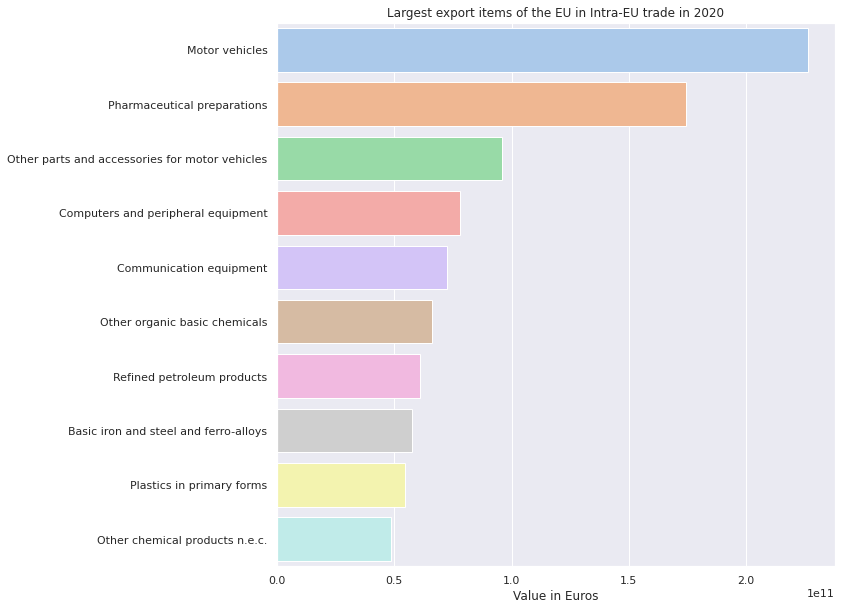

In [15]:
# Plot the largest intra-EU export items
plt.figure(figsize=(10,10))
sns.barplot(x=largest_exports_intra.values[1:], y=largest_exports_intra_labels[1:])
plt.title("Largest export items of the EU in Intra-EU trade in 2020")
plt.xlabel("Value in Euros")
plt.show()

From the plot above we can see that within the EU in 2020, Motor vehicles were the largest valued exported product.

### 4. Check what the most exported items were to Great Britain in 2020 in terms of value

In [16]:
# Query the largest export items to GB based on "VALUE_IN_EUROS"
largest_exports_GB = raw_data[(raw_data["FLOW"]==2) & (raw_data["TRADE_TYPE"]=='K')].groupby(["PRODUCT_CPA2_1"])["VALUE_IN_EUROS"].sum().nlargest(11, keep="first")
print(largest_exports_GB, end="\n\n")

# Create a list of labels for the top export items
largest_exports_GB_labels = []
for code in largest_exports_GB.index.tolist():
  largest_exports_GB_labels.append(CPA_list[CPA_list["CODE"] == code].iloc[0]["DESCRIPTION"])

PRODUCT_CPA2_1
TOTAL    252867617020
2910      30593390502
2120      14901476711
2620       7053294225
2932       6420996236
2441       5748452273
2630       5482218295
3030       5026864212
2059       4207722696
3250       4095793781
2014       4049572485
Name: VALUE_IN_EUROS, dtype: int64



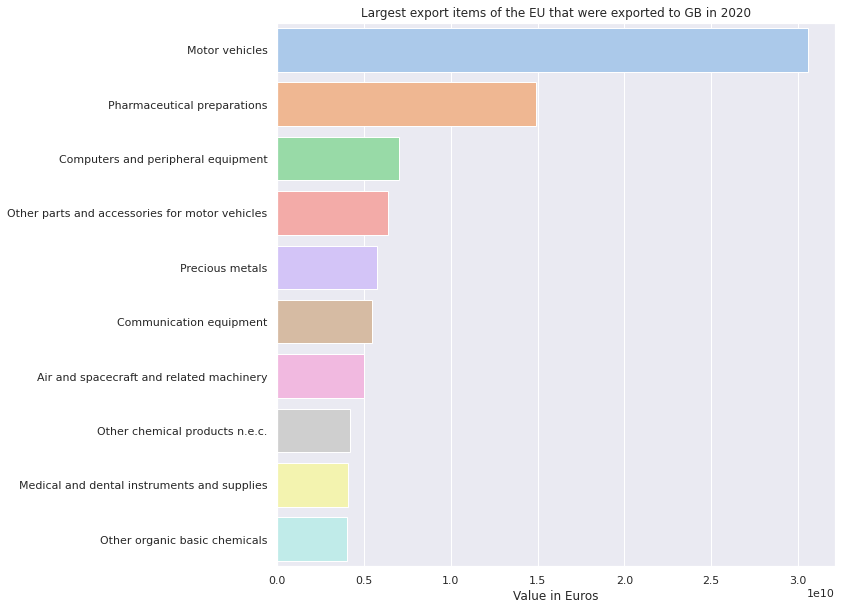

In [17]:
# Plot the largest export items that were exported to GB in 2020
plt.figure(figsize=(10,10))
sns.barplot(x=largest_exports_GB.values[1:], y=largest_exports_GB_labels[1:])
plt.title("Largest export items of the EU that were exported to GB in 2020")
plt.xlabel("Value in Euros")
plt.show()

We can see that the top three exported products to Great Britain were motor vehicles, pharmaceutical preparations and computers in 2020. 

### 5. Check what the most imported items were in the EU in 2020 in terms of value

In [18]:
# Query the largest import items in the EU based on "VALUE_IN_EUROS"
largest_imports = raw_data[(raw_data["FLOW"]==1)].groupby(["PRODUCT_CPA2_1"])["VALUE_IN_EUROS"].sum().nlargest(11, keep="first")
print(largest_imports, end="\n\n")

# Create a list of labels for the top import items
largest_imports_labels = []
for code in largest_imports.index.tolist():
  largest_imports_labels.append(CPA_list[CPA_list["CODE"] == code].iloc[0]["DESCRIPTION"])

PRODUCT_CPA2_1
TOTAL    4546969866885
2910      286381684064
2120      256915899307
2620      151611868065
2630      146619485712
0610      140781570173
2932      123165046137
2014      112948165504
1920      104769417528
2410       79809945486
3030       75388631031
Name: VALUE_IN_EUROS, dtype: int64



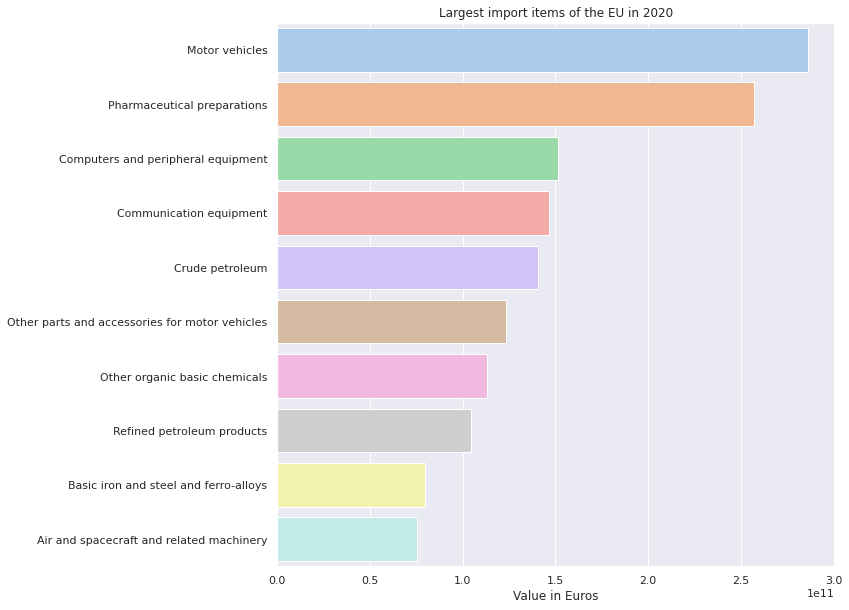

In [19]:
# Plot the largest import items in the EU
plt.figure(figsize=(10,10))
sns.barplot(x=largest_imports.values[1:], y=largest_imports_labels[1:])
plt.title("Largest import items of the EU in 2020")
plt.xlabel("Value in Euros")
plt.show()

We can see that the largest imported items in the EU are, among others, motor vehicles, pharmaceutical preparations and computers. However, these include both intra and extra EU imports, so next I will check the most imported products from outside of the EU. 

In [20]:
# Query the largest import items in extra-EU trade based on "VALUE_IN_EUROS"
largest_imports_extra = raw_data[(raw_data["FLOW"]==1) & (raw_data["TRADE_TYPE"]=='E')].groupby(["PRODUCT_CPA2_1"])["VALUE_IN_EUROS"].sum().nlargest(11, keep="first")
print(largest_imports_extra, end="\n\n")

# Create a list of labels for the top import items
largest_imports_extra_labels = []
for code in largest_imports_extra.index.tolist():
  largest_imports_extra_labels.append(CPA_list[CPA_list["CODE"] == code].iloc[0]["DESCRIPTION"])

PRODUCT_CPA2_1
TOTAL    1572741043945
0610      119955923629
2630       78469450806
2620       71961837437
2120       68471449649
2910       51397534181
2014       41573547449
1920       40628289262
2611       40353362670
3030       37931338865
3250       30023586062
Name: VALUE_IN_EUROS, dtype: int64



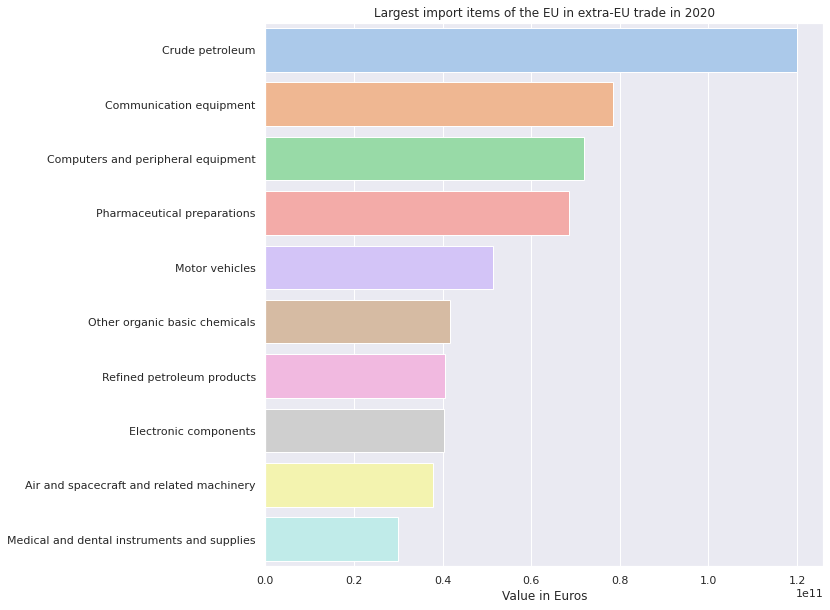

In [21]:
# Plot the largest import items of the EU in extra-EU trade
plt.figure(figsize=(10,10))
sns.barplot(x=largest_imports_extra.values[1:], y=largest_imports_extra_labels[1:])
plt.title("Largest import items of the EU in extra-EU trade in 2020")
plt.xlabel("Value in Euros")
plt.show()

While motor vehicles, computers and pharmaceutical preparations are still some of the largest imported products to the EU, when only considering Extra-EU trade, crude petroleum and communication equipment are the two biggest import products in 2020. 

### 6. Country specific exports

In this section I focus on country specific exports. First, I will check the top exporters in the EU and then further investigate the biggest exporter country in terms of export products and partners. 

#### 6.1 Check what countries have the highest overall valued exports

In [22]:
# Query the countries that export the most in the EU in terms of "VALUE_IN_EUROS"
largest_exports_country = raw_data[(raw_data["FLOW"]==2)].groupby(["DECLARANT_ISO"])["VALUE_IN_EUROS"].sum().nlargest(5, keep="first")
print(largest_exports_country, end="\n\n")

# Create a list of labels for the top export countries
largest_exports_country_labels = []
for country in largest_exports_country.index.tolist():
  largest_exports_country_labels.append(raw_data[raw_data["DECLARANT_ISO"] == country].iloc[0]["DECLARANT_ISO"])

DECLARANT_ISO
DE    2415089708486
NL    1180578348436
IT     867118614056
FR     853988420748
BE     735092986910
Name: VALUE_IN_EUROS, dtype: int64



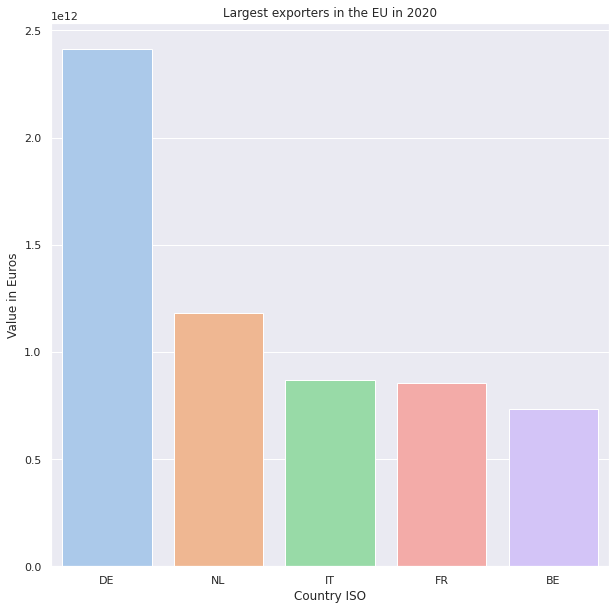

In [23]:
# Plot the largest exporters in the EU
plt.figure(figsize=(10,10))
sns.barplot(x=largest_exports_country_labels, y=largest_exports_country.values, orient="v")
plt.title("Largest exporters in the EU in 2020")
plt.ylabel("Value in Euros")
plt.xlabel("Country ISO")
plt.show()

The country that exported the most in 2020, in the EU is Germany.
So next, I check what the top export products are for Germany.

#### 6.2 Check what products Germany exports the most

In [24]:
# Query the products that Germany exports the most in terms of "VALUE_IN_EUROS"
largest_exports_DE = raw_data[(raw_data["DECLARANT_ISO"]=="DE") & (raw_data["FLOW"]==2)].groupby(["PRODUCT_CPA2_1"])["VALUE_IN_EUROS"].sum().nlargest(11, keep="first")
print(largest_exports_DE, end="\n\n")

# Create a list of labels for the top export items
largest_exports_DE_labels = []
for code in largest_exports_DE.index.tolist():
  largest_exports_DE_labels.append(CPA_list[CPA_list["CODE"] == code].iloc[0]["DESCRIPTION"])

PRODUCT_CPA2_1
TOTAL    1207544854243
2910      130803201231
2120       82845642324
2932       47920186466
3030       30859173056
2651       30474515450
2059       23536882763
SSSS       23060596343
2829       21709485708
2014       20002631752
2620       19448085462
Name: VALUE_IN_EUROS, dtype: int64



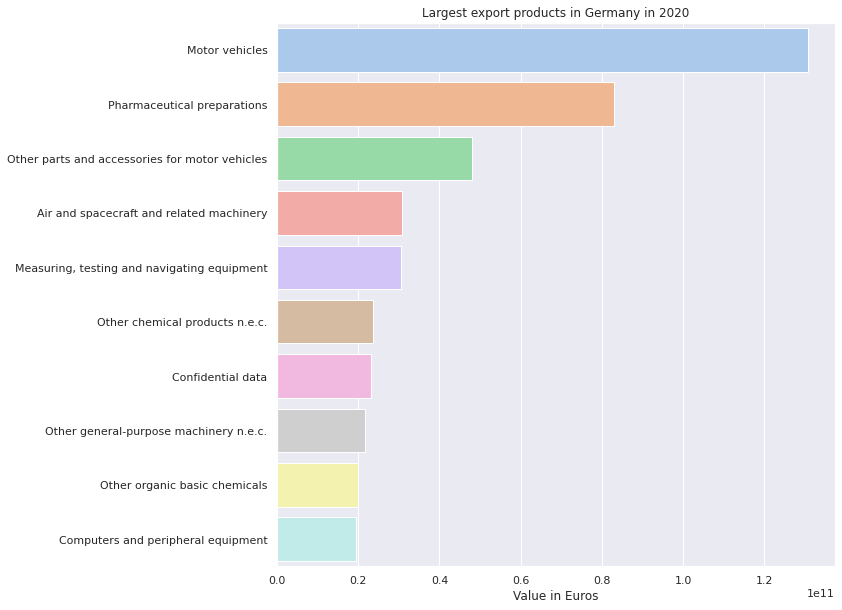

In [25]:
# Plot the largest export products of Germany in 2020
plt.figure(figsize=(10,10))
sns.barplot(x=largest_exports_DE.values[1:], y=largest_exports_DE_labels[1:])
plt.title("Largest export products in Germany in 2020")
plt.xlabel("Value in Euros")
plt.show()

We can see that motor vehicles are the highest valued export product of Germany in 2020.


#### 6.3 Check the biggest export partners of Germany

In [26]:
# Query Germany's biggest export partners
largest_exp_partners_DE = raw_data[(raw_data["DECLARANT_ISO"]=="DE") & (raw_data["FLOW"]==2)].groupby(["PARTNER_ISO"])["VALUE_IN_EUROS"].sum().nlargest(5, keep="first")
print(largest_exp_partners_DE, end="\n\n")

# Create a list of labels for the top export partners
largest_exp_partners_DE_labels = []
for country in largest_exp_partners_DE.index.tolist():
  largest_exp_partners_DE_labels.append(raw_data[raw_data["PARTNER_ISO"] == country].iloc[0]["PARTNER_ISO"])

PARTNER_ISO
US    208191748306
CN    192824125405
FR    181385471911
NL    162333731385
GB    133427685920
Name: VALUE_IN_EUROS, dtype: int64



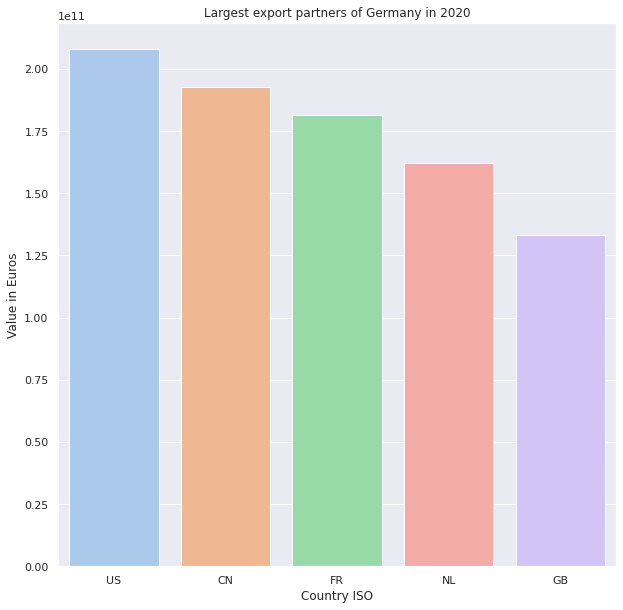

In [27]:
# Plot the largest export partners of Germany
plt.figure(figsize=(10,10))
sns.barplot(x=largest_exp_partners_DE_labels, y=largest_exp_partners_DE.values, orient="v")
plt.title("Largest export partners of Germany in 2020")
plt.ylabel("Value in Euros")
plt.xlabel("Country ISO")
plt.show()

From the figure above, we can see that the biggest export partner of Germany is the United States, closely followed by Canada and France.

### 7. Check which EU country is the biggest wine exporter

Lastly, I want to see whether there is a difference between the top exporters of a product when the exports are based on value or the quantity of the product.

For this, I have chosen to examine wine exports as there exists data on both its value and quantity. 

According to the CPA 2.1 classification: all product codes which start with 1102 are wine from grapes. 

So first I identify the top 5 wine exporters in the EU based on the yearly total value of wine exports.

In [28]:
# Query the biggest wine exporters in terms of value
wine_exp_euro = raw_data[(raw_data["FLOW"]==2) & raw_data["PRODUCT_CPA2_1"].str.startswith('1102')].groupby(["DECLARANT_ISO"])["VALUE_IN_EUROS"].sum().nlargest(5, keep='first')
print(wine_exp_euro, end="\n\n")

# Create a list of labels
wine_exp_euro_labels = []
for country in wine_exp_euro.index.tolist():
  wine_exp_euro_labels.append(raw_data[raw_data["DECLARANT_ISO"] == country].iloc[0]["DECLARANT_ISO"])

DECLARANT_ISO
FR    8719665366
IT    6291355103
ES    2682126625
DE     907776602
PT     847326072
Name: VALUE_IN_EUROS, dtype: int64



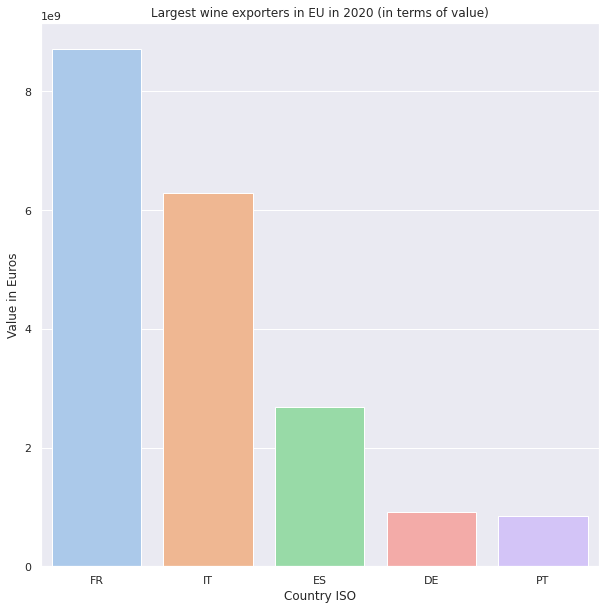

In [29]:
# Plot the largest wine exporters in 2020
plt.figure(figsize=(10,10))
sns.barplot(x=wine_exp_euro_labels, y=wine_exp_euro.values, orient="v")
plt.title("Largest wine exporters in EU in 2020 (in terms of value)")
plt.ylabel("Value in Euros")
plt.xlabel("Country ISO")
plt.show()

We can see that the top 5 wine exporters in the EU are: France, Italy, Spain, Germany and Portugal.

Now, I will also identify the top 5 wine exporters in the EU based on the yearly exported wine quantity.

In [30]:
# Query the biggest wine exporters in terms of quantity
wine_exp_kg = raw_data[(raw_data["FLOW"]==2) & raw_data["PRODUCT_CPA2_1"].str.startswith('1102')].groupby(["DECLARANT_ISO"])["QUANTITY_IN_KG"].sum().nlargest(5, keep='first')
print(wine_exp_kg, end="\n\n")

# Create a list of labels
wine_exp_kg_labels = []
for country in wine_exp_kg.index.tolist():
  wine_exp_kg_labels.append(raw_data[raw_data["DECLARANT_ISO"] == country].iloc[0]["DECLARANT_ISO"])

DECLARANT_ISO
ES    2108544011
IT    2098268496
FR    1420680576
DE     362260286
PT     314315021
Name: QUANTITY_IN_KG, dtype: int64



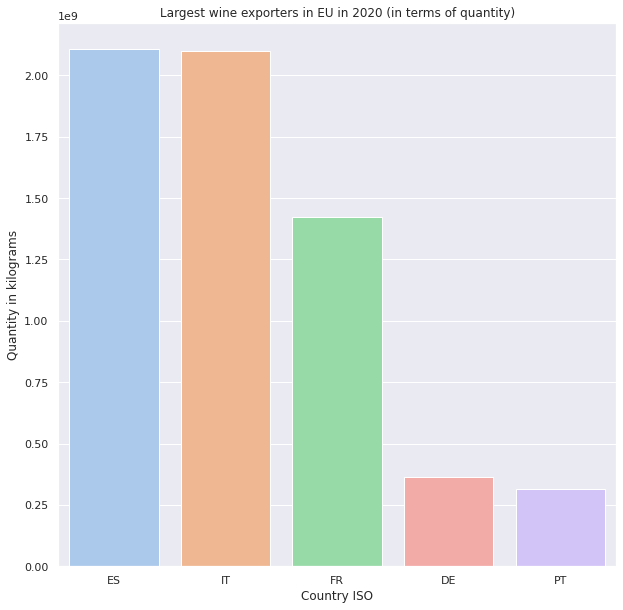

In [31]:
# Plot the largest wine exporters in terms of quantity
plt.figure(figsize=(10,10))
sns.barplot(x=wine_exp_kg_labels, y=wine_exp_kg.values, orient="v")
plt.title("Largest wine exporters in EU in 2020 (in terms of quantity)")
plt.ylabel("Quantity in kilograms")
plt.xlabel("Country ISO")
plt.show()

We can see that while France was the wine exporter with the highest value, Spain was the largest wine exporter in terms of quantity in 2020.